<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deeptrack
!pip install --pre deeplay
!pip install einops

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### **Getting data from Deeptrack**

In [2]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

# Getting just two images for pretraining the CNN
two_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=2,
)
two_img_dataset = two_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

### **Exporing dataset**

In [3]:
# Generate a single batch of images
batch = dataset.update()()

# Get unique pixel values
unique_values = np.unique(batch)
print(unique_values)
print(len(unique_values))
print(np.max(unique_values))

# Check if the unique pixel values are binary
is_binary = len(unique_values) == 2 and (0 in unique_values) and (1 in unique_values)

if is_binary:
    print("The pixel values are binary (0 and 1).")
else:
    print("The pixel values are not binary.")

[9.23851199e-03 9.25013540e-03 9.27449813e-03 ... 2.00803056e+01
 2.00830488e+01 2.00966394e+01]
40960
20.096639374193416
The pixel values are not binary.


### **Plotting the images**

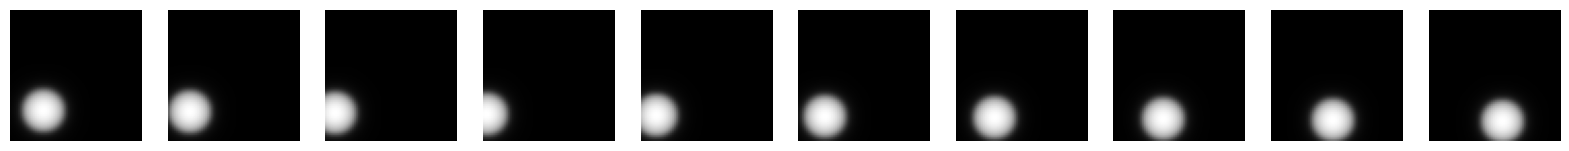

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_images(images):
    # Check if the input is a list of numpy arrays
    if isinstance(images, list):
        num_images = len(images)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
        for i, img in enumerate(images):
            if img.ndim == 3 and img.shape[2] == 1:  # [H, W, 1] images
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dim if it's 1
                ax.axis('off')
            else:
                raise ValueError("Image format not supported or needs additional handling for more channels.")

    # Check if the input is a PyTorch tensor
    elif isinstance(images, torch.Tensor):
        if images.dim() == 4:  # Batch of images [N, C, H, W]
            images = images.detach().cpu().numpy()  # Convert to numpy
            num_images = images.shape[0]
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figure size as needed
            for i, img in enumerate(images):
                img = img.squeeze() if img.shape[0] == 1 else np.transpose(img, (1, 2, 0))
                ax = axes[i] if num_images > 1 else axes
                ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
                ax.axis('off')
        else:
            raise ValueError("Tensor dimension not supported for visualization.")
    else:
        raise ValueError("Unsupported data type for the images.")

# Example of how to use the function:
# Assuming 'batch' is a list of numpy arrays from dataset.update()
plot_images(batch)

### **Creating Datasets and DataLoaders**

In [85]:
import torch
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import numpy as np

def generate_data(dataset, size = 256):
  data = []
  for i in range(math.floor(size/2)):
    data += dataset.update()()
  return data

#train_df = generate_data(two_img_dataset, size = 256)
#print(len(test_data))
#plot_images(test_data[:16])

import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, pregenerated_data):
      # Calculate mean and standard deviation for z-score normalization
        all_data = np.concatenate([image.flatten() for image in pregenerated_data])
        self.mean = np.mean(all_data)
        #print(self.mean)
        self.std = np.std(all_data)
        #print(self.std)

        # Normalize images
        self.data = [
            torch.tensor((np.moveaxis(image, -1, 0).copy() - self.mean) / self.std, dtype=torch.float32)
            for image in pregenerated_data
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Assuming two_img_dataset and generate_data are properly defined and used as before
train_df = generate_data(two_img_dataset, size = 256)
train_data = CustomDataset(train_df)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_df = generate_data(two_img_dataset, size = 256)
val_data = CustomDataset(val_df)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

test_df = generate_data(two_img_dataset, size = 256)
test_data = CustomDataset(test_df)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)




In [79]:
import torch

def test_normalization(loader):
    # Variables to accumulate batch means and standard deviations
    batch_means = []
    batch_stds = []

    # Loop through batches in the DataLoader
    for images in loader:
        # Calculate mean and std per batch
        batch_mean = images.mean()
        batch_std = images.std()

        # Store the batch mean and std
        batch_means.append(batch_mean.item())
        batch_stds.append(batch_std.item())

    # Calculate the overall mean and std from all batches
    overall_mean = sum(batch_means) / len(batch_means)
    overall_std = sum(batch_stds) / len(batch_stds)

    return overall_mean, overall_std

# Apply the test function to your train_loader
mean, std = test_normalization(train_loader)
print(f"Mean of the batches in the train loader: {mean}")
print(f"Standard deviation of the batches in the train loader: {std}")


Mean of the batches in the train loader: -1.1714291758835316e-09
Standard deviation of the batches in the train loader: 0.9932191297411919


In [81]:
def compute_global_stats(dataset):
    all_data = torch.cat([image.unsqueeze(0) for image in dataset.data])
    global_mean = all_data.mean()
    global_std = all_data.std()

    print(f"Recomputed Global Mean: {global_mean}")
    print(f"Recomputed Global Std: {global_std}")

# Assuming train_data is your dataset instance
compute_global_stats(train_data)


Recomputed Global Mean: -4.656612873077393e-10
Recomputed Global Std: 1.0000004768371582


## **Checking how the images looks and that the dimensions are correct**

torch.Size([1, 64, 64])


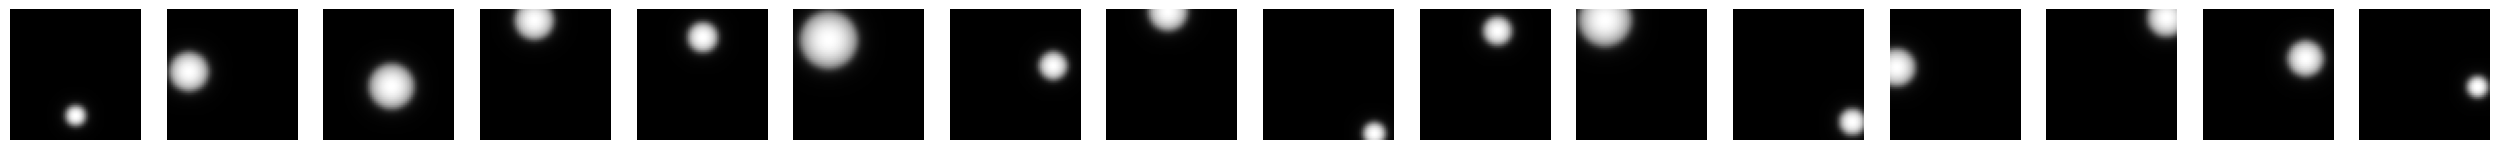

In [80]:
# Fetch one batch from the DataLoader
for images in train_loader:
    # Assuming plot_images is defined to handle a batch of images
    print(images[0].shape)  # Pass the tensor directly if your function handles tensor input
    plot_images(images)
    break  # Exit after the first batch


### **Creating the CNN**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model8(nn.Module):
    def __init__(self):
        super(Model8, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),  # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),   # [batch, 8, H/16, W/16]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 3, stride=2, padding=1, output_padding=1),    # [batch, 32, H/8, W/8]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),   # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),    # [batch, 1, H, W]
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model64(nn.Module):
    def __init__(self):
        super(Model64, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [batch, 64, H/8, W/8]
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, H/4, W/4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, H/2, W/2]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [batch, 1, H, W]
            #nn.ReLU()  # Assuming the input is scaled between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model128(nn.Module):
    def __init__(self):
        super(Model128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model256(nn.Module):
    def __init__(self):
        super(Model256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class Model512(nn.Module):
    def __init__(self):
        super(Model512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training the models**

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_nn(model, val_loader, optimizer, loss_fn, num_epochs):
    model.to(device)

    # Store losses to return
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        train_df = generate_data(two_img_dataset, size = 256)
        train_data = CustomDataset(train_df)
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * images.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, images)
                total_val_loss += loss.item() * images.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Print losses for the epoch
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


### **Models with different bottleneck sizes**

In [34]:
# Create the model with bottleneck 64
model8 = Model8().to(device)

In [35]:
# Define the optimizer and loss function
optimizer = optim.Adam(model8.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses8, val_losses8 = train_nn(model8, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 1.0348, Val Loss: 0.9991
Epoch 2/10 - Train Loss: 0.7578, Val Loss: 0.5103
Epoch 3/10 - Train Loss: 0.3648, Val Loss: 0.2780
Epoch 4/10 - Train Loss: 0.2090, Val Loss: 0.1624
Epoch 5/10 - Train Loss: 0.1292, Val Loss: 0.1223
Epoch 6/10 - Train Loss: 0.0887, Val Loss: 0.0974
Epoch 7/10 - Train Loss: 0.0740, Val Loss: 0.0847
Epoch 8/10 - Train Loss: 0.0668, Val Loss: 0.0762
Epoch 9/10 - Train Loss: 0.0661, Val Loss: 0.0651
Epoch 10/10 - Train Loss: 0.0670, Val Loss: 0.0600


In [36]:
# Create the model with bottleneck 64
model64 = Model64().to(device)

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model64.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses64, val_losses64 = train_nn(model64, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.9064, Val Loss: 0.5374
Epoch 2/10 - Train Loss: 0.3513, Val Loss: 0.1943
Epoch 3/10 - Train Loss: 0.1295, Val Loss: 0.0998
Epoch 4/10 - Train Loss: 0.0692, Val Loss: 0.0659
Epoch 5/10 - Train Loss: 0.0439, Val Loss: 0.0436
Epoch 6/10 - Train Loss: 0.0351, Val Loss: 0.0338
Epoch 7/10 - Train Loss: 0.0294, Val Loss: 0.0254
Epoch 8/10 - Train Loss: 0.0212, Val Loss: 0.0253
Epoch 9/10 - Train Loss: 0.0202, Val Loss: 0.0202
Epoch 10/10 - Train Loss: 0.0150, Val Loss: 0.0155


In [37]:
model128 = Model128().to(device)

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model128.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses128, val_losses128 = train_nn(model128, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.7812, Val Loss: 0.3583
Epoch 2/10 - Train Loss: 0.2240, Val Loss: 0.1064
Epoch 3/10 - Train Loss: 0.0857, Val Loss: 0.0622
Epoch 4/10 - Train Loss: 0.0514, Val Loss: 0.0415
Epoch 5/10 - Train Loss: 0.0379, Val Loss: 0.0281
Epoch 6/10 - Train Loss: 0.0244, Val Loss: 0.0221
Epoch 7/10 - Train Loss: 0.0218, Val Loss: 0.0184
Epoch 8/10 - Train Loss: 0.0147, Val Loss: 0.0122
Epoch 9/10 - Train Loss: 0.0122, Val Loss: 0.0105
Epoch 10/10 - Train Loss: 0.0115, Val Loss: 0.0099


In [38]:
model256 = Model256().to(device)

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model256.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses256, val_losses256 = train_nn(model256, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.8272, Val Loss: 0.3988
Epoch 2/10 - Train Loss: 0.2267, Val Loss: 0.1062
Epoch 3/10 - Train Loss: 0.0871, Val Loss: 0.0733
Epoch 4/10 - Train Loss: 0.0606, Val Loss: 0.0420
Epoch 5/10 - Train Loss: 0.0418, Val Loss: 0.0292
Epoch 6/10 - Train Loss: 0.0258, Val Loss: 0.0208
Epoch 7/10 - Train Loss: 0.0193, Val Loss: 0.0146
Epoch 8/10 - Train Loss: 0.0138, Val Loss: 0.0125
Epoch 9/10 - Train Loss: 0.0121, Val Loss: 0.0097
Epoch 10/10 - Train Loss: 0.0089, Val Loss: 0.0085


In [39]:
model512 = Model512().to(device)

In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model512.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Number of epochs to train
num_epochs = 10

# Train the network
train_losses512, val_losses512 = train_nn(model512, val_loader, optimizer, loss_fn, num_epochs)

Epoch 1/10 - Train Loss: 0.3677, Val Loss: 0.0861
Epoch 2/10 - Train Loss: 0.0595, Val Loss: 0.0337
Epoch 3/10 - Train Loss: 0.0296, Val Loss: 0.0210
Epoch 4/10 - Train Loss: 0.0194, Val Loss: 0.0137
Epoch 5/10 - Train Loss: 0.0107, Val Loss: 0.0078
Epoch 6/10 - Train Loss: 0.0077, Val Loss: 0.0063
Epoch 7/10 - Train Loss: 0.0062, Val Loss: 0.0042
Epoch 8/10 - Train Loss: 0.0047, Val Loss: 0.0033
Epoch 9/10 - Train Loss: 0.0036, Val Loss: 0.0030
Epoch 10/10 - Train Loss: 0.0034, Val Loss: 0.0034


### **Visualizing the results**

In [ ]:
# Assuming all models were trained for the same number of epochs
epochs = range(1, len(val_losses8) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses8, label='Bottleneck 8', marker='o')
plt.plot(epochs, val_losses64, label='Bottleneck 64', marker='o')
plt.plot(epochs, val_losses128, label='Bottleneck 128', marker='o')
plt.plot(epochs, val_losses256, label='Bottleneck 256', marker='o')
plt.plot(epochs, val_losses512, label='Bottleneck 512', marker='o')

plt.title('Validation Loss Across Different Bottleneck Sizes')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

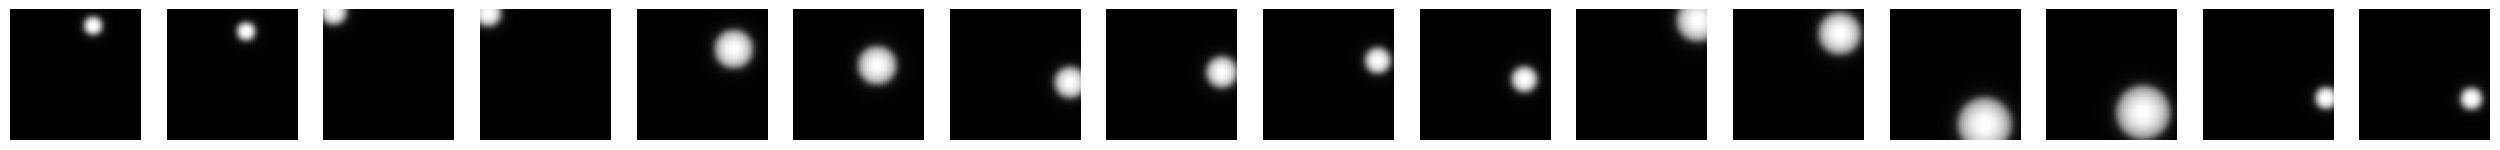

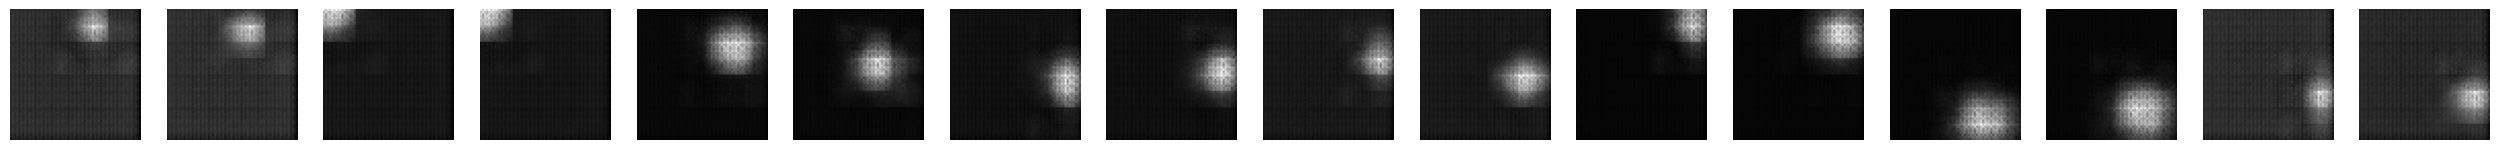

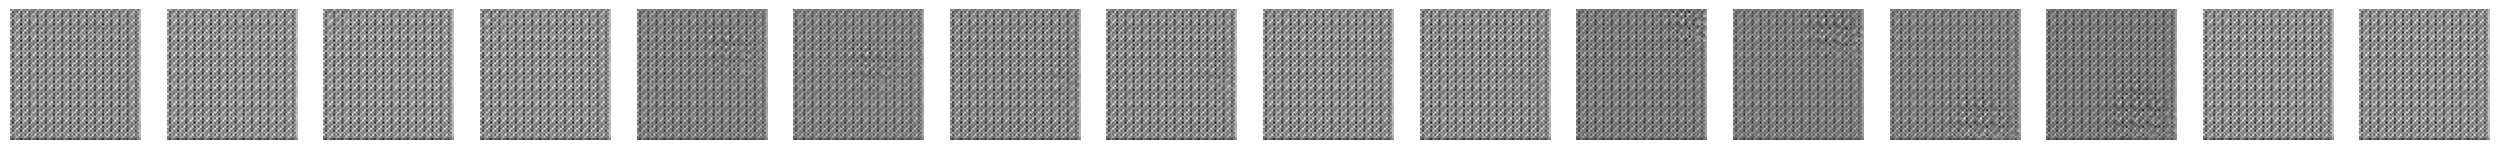

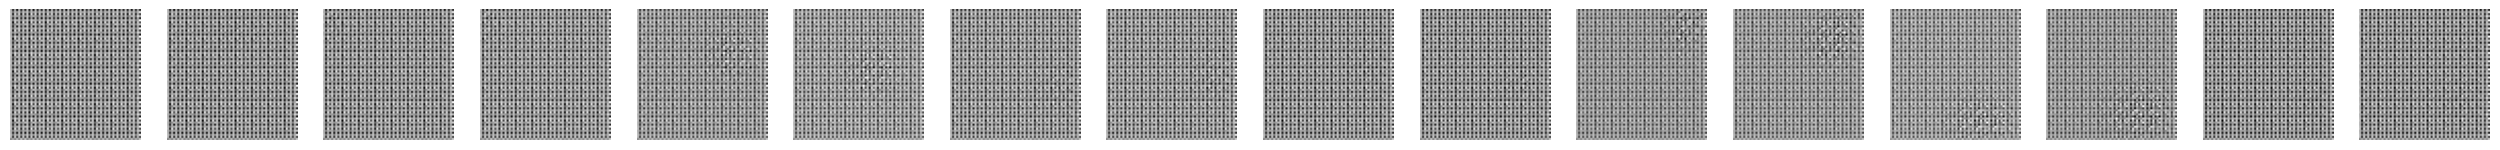

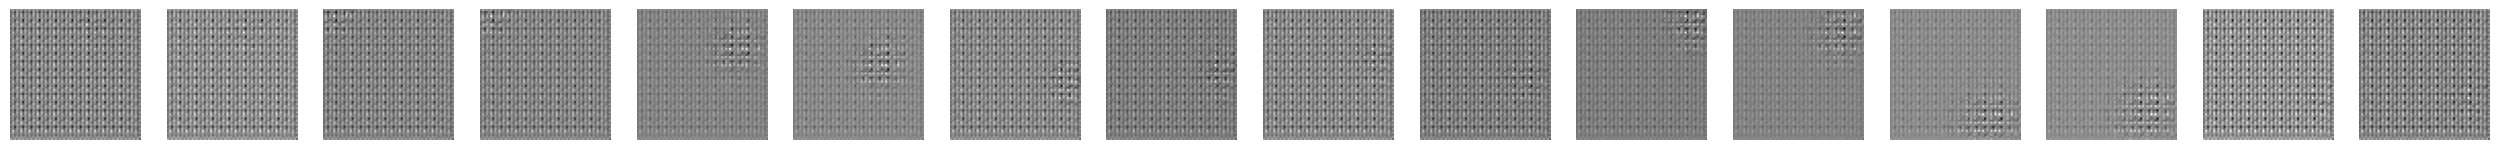

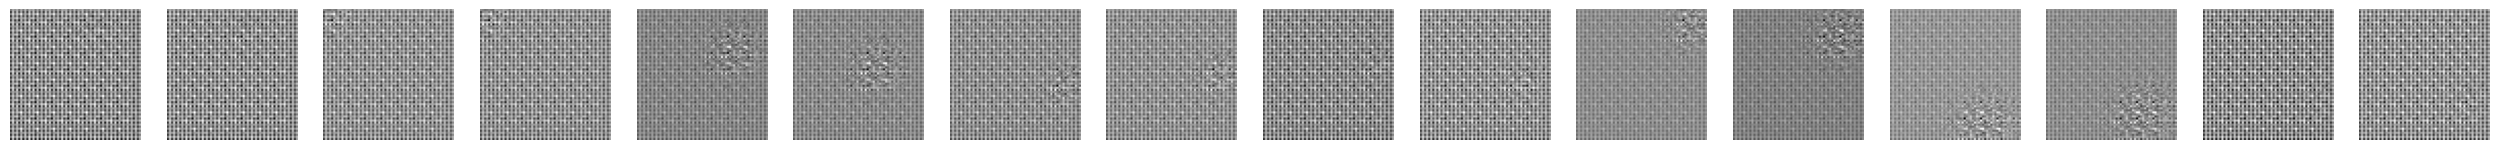

In [82]:
# Process images from test_loader
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        break  # Remove break to process more batches

### **Transformer Encoder**

In [86]:
import torch
import torch.nn as nn

class PatchEmbedder(nn.Module):
  def __init__(self, height = 64, width = 64, im_channels = 1, emb_dim = 128, patch_size = 8):
        super().__init__()
        self.height = height
        self.width = width
        self.im_channels = im_channels
        self.emb_dim = emb_dim
        self.patch_size = patch_size
        self.nPatches = int((self.height / self.patch_size) * (self.width / self.patch_size))
        # Layers and embeddings
        self.patch_conv_layer = nn.Conv2d(in_channels = self.im_channels,
                                          out_channels = self.emb_dim,
                                          kernel_size=self.patch_size,
                                          stride = self.patch_size)
        self.linearProj = nn.Linear(in_features = emb_dim,
                                    out_features=emb_dim)

        scale = 0.02  # Commonly used scaling factor in transformer models
        self.pos_emb = nn.Parameter(torch.randn(1, self.nPatches + 1, self.emb_dim) * scale)
        #self.pos_emb = nn.Parameter(torch.randn(1, self.nPatches + 1, self.emb_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_dim))

  def forward(self, x):                                                 # Example shapes
    x = self.patch_conv_layer(x)                                        # [16,1,64,64] --> [16, 128, 8, 8]
    x = x.flatten(2)                                                    # [16, 128, 8, 8] --> [16, 128, 64]
    x = x.transpose(1, 2)                                               # [16, 128, 64] --> [16, 64, 128]
    x = self.linearProj(x)                                              # [16, 64, 128] --> [16, 64, 128]
    x = torch.cat((self.cls_token.repeat(x.shape[0], 1, 1), x), dim=1)  # [16, 64, 128] --> [16, 65, 128]
    x += self.pos_emb                                                   # [16, 64, 128] --> [16, 65, 128]
    return x

test_input = torch.randn(16, 1, 64, 64)
patch_embedder = PatchEmbedder()
output = patch_embedder(test_input)
output.shape

torch.Size([16, 65, 128])

In [44]:
import torch
import torch.nn as nn

class TransformerEncoder(nn.Module):
  def __init__(self, emb_dim = 128, nHeads = 4, dropoutRate = 0.1):
    super().__init__()
    self.emb_dim = emb_dim
    self.nHeads = nHeads
    self.dropoutRate = dropoutRate
    # Layers and normalization
    self.normLayer1 = nn.LayerNorm(self.emb_dim)
    self.normLayer2 = nn.LayerNorm(self.emb_dim)

    self.multihead = nn.MultiheadAttention(self.emb_dim, self.nHeads, self.dropoutRate)
    self.MLP = nn.Sequential(
      nn.Linear(emb_dim, emb_dim * 2),  # First linear layer
      nn.GELU(),                                # GELU activation function
      nn.Linear(emb_dim * 2, emb_dim)  # Second linear layer
      )

  def forward(self, x):
    xnorm = self.normLayer1(x)
    attention, weights = self.multihead(xnorm, xnorm, xnorm)
    x = x + attention
    xnorm2 = self.normLayer2(x)
    out = self.MLP(xnorm2)
    x = x + out
    return x

encoder = TransformerEncoder()
output2 = encoder(output)
print(output2.shape)


torch.Size([16, 65, 128])


In [90]:
class VisionTransformer(nn.Module):
  def __init__(self, height = 64, width = 64, im_channels = 1, emb_dim = 128, patch_size = 8, nHeads = 8, dropoutRate = 0.1, nEncoders = 1):
    super().__init__()
    self.height = height
    self.width = width
    self.im_channels = im_channels
    self.emb_dim = emb_dim
    self.patch_size = patch_size
    self.nHeads = nHeads
    self.dropoutRate = dropoutRate
    self.nEncoders = nEncoders

    self.patchEmbedder = PatchEmbedder(height = self.height,
                                       width = self.width,
                                       im_channels = self.im_channels,
                                       emb_dim = self.emb_dim,
                                       patch_size = self.patch_size)

    self.transformerEncoder = TransformerEncoder(emb_dim = self.emb_dim,
                                                 nHeads = self.nHeads,
                                                 dropoutRate = self.dropoutRate,)

    self.MLP = nn.Sequential(nn.Linear(emb_dim, emb_dim * 2),
                             nn.ReLU(),
                             nn.Linear(emb_dim * 2, emb_dim),
                             nn.ReLU())

    self.decoder = model8.decoder.to(device)

  def forward(self, x):
    # Patch the images
    x = self.patchEmbedder(x)

    # Run it through the encoderlayer nEncoder times
    for _ in range(self.nEncoders):
      x = self.transformerEncoder(x)
    #print(x.shape)
    # Run the class tokens through the MLP and reshape to fit the decoder
    cls_tokens = x[:, 0, :]
    cls_tokens_MLP = self.MLP(cls_tokens)
    #print(x.shape)
    cls_tokens_reshaped = cls_tokens_MLP.reshape(-1, 8, 4, 4).to(device)
    #print(cls_tokens_reshaped.shape)
    # Decode the latent representation
    x = self.decoder(cls_tokens_reshaped)

    return x


ViT = VisionTransformer()
output3 = ViT(test_input)
output3.shape


torch.Size([16, 1, 64, 64])

In [91]:
ViT = VisionTransformer()

criterion = nn.MSELoss()  # Assuming reconstruction task
optimizer = torch.optim.Adam(ViT.parameters(), lr=0.001)

train_nn(ViT, val_loader, optimizer, criterion, 50)

Epoch 1/50 - Train Loss: 1.0003, Val Loss: 1.0016
Epoch 2/50 - Train Loss: 0.9986, Val Loss: 1.0010
Epoch 3/50 - Train Loss: 0.9969, Val Loss: 0.9988
Epoch 4/50 - Train Loss: 0.9993, Val Loss: 0.9973
Epoch 5/50 - Train Loss: 0.9986, Val Loss: 0.9970
Epoch 6/50 - Train Loss: 0.9987, Val Loss: 0.9971
Epoch 7/50 - Train Loss: 0.9989, Val Loss: 0.9974
Epoch 8/50 - Train Loss: 0.9953, Val Loss: 0.9995
Epoch 9/50 - Train Loss: 0.9985, Val Loss: 0.9985
Epoch 10/50 - Train Loss: 0.9988, Val Loss: 0.9981
Epoch 11/50 - Train Loss: 0.9961, Val Loss: 0.9986
Epoch 12/50 - Train Loss: 0.9973, Val Loss: 0.9984
Epoch 13/50 - Train Loss: 0.9941, Val Loss: 0.9991
Epoch 14/50 - Train Loss: 1.0014, Val Loss: 0.9970
Epoch 15/50 - Train Loss: 0.9993, Val Loss: 0.9974
Epoch 16/50 - Train Loss: 0.9972, Val Loss: 0.9974
Epoch 17/50 - Train Loss: 0.9967, Val Loss: 0.9980
Epoch 18/50 - Train Loss: 0.9967, Val Loss: 0.9983
Epoch 19/50 - Train Loss: 0.9962, Val Loss: 0.9970
Epoch 20/50 - Train Loss: 0.9976, Val Lo

([1.0002686977386475,
  0.9986117333173752,
  0.996853444725275,
  0.9992640912532806,
  0.9986276142299175,
  0.9987059831619263,
  0.9988823235034943,
  0.9952685758471489,
  0.9984812662005424,
  0.9987519234418869,
  0.9960803017020226,
  0.9973330162465572,
  0.9941100291907787,
  1.0013987459242344,
  0.9993201233446598,
  0.9972480274736881,
  0.9966963082551956,
  0.9966649953275919,
  0.9961576499044895,
  0.9975739382207394,
  0.9966795481741428,
  0.9981369487941265,
  0.9962519314140081,
  0.9958134964108467,
  0.9964421167969704,
  1.0010131187736988,
  0.9995170682668686,
  0.9977302998304367,
  0.9966580383479595,
  0.9964541494846344,
  0.997711218893528,
  0.9980016015470028,
  0.9980165138840675,
  0.9980666004121304,
  0.9988047108054161,
  0.998018741607666,
  0.9980201460421085,
  0.9971771463751793,
  0.9954433254897594,
  0.9985682442784309,
  0.9982337579131126,
  0.999574963003397,
  0.9971261024475098,
  0.9970426894724369,
  0.9953867197036743,
  0.9984864853

In [ ]:
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)

        plot_images(images)

        outputs8 = model8(images)
        plot_images(outputs8)

        outputs64 = model64(images)
        plot_images(outputs64)

        outputs128 = model128(images)
        plot_images(outputs128)

        outputs256 = model256(images)
        plot_images(outputs256)

        outputs512 = model512(images)
        plot_images(outputs512)

        outputsViT = ViT(images)
        plot_images(outputsViT)

        break  # Remove break to process more batches